torch.Size([60000, 28, 28])
torch.Size([60000])


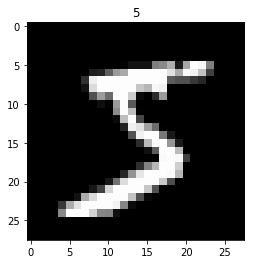

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
Epoch:  0 | train loss: 2.3104 | test accuracy: 0.10
Epoch:  0 | train loss: 0.8963 | test accuracy: 0.59
Epoch:  0 | train loss: 0.8892 | test accuracy: 0.71
Epoch:  0 | train loss: 0.4542 | test accuracy: 0.78
Epoch:  0 | train loss: 0.4029 | test accuracy: 0.84
Epoch:  0 | train loss: 0.4129 | test accuracy: 0.88
Epoch:  0 | train loss: 0.3070 | test accuracy: 0.88
Epoch:  0 | train loss: 0.2716 | test accuracy: 0.91
Epoch:  0 | train loss: 0.1901 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3085 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1015 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1524 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1768 | test accuracy: 0.90
Epoch:  0 | train loss: 0.1301 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1732 | test accuracy: 0.95
Epoch:  0 | train loss: 0.2909 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1948 | test accurac

AttributeError: 'Tensor' object has no attribute 'empty_cache'

In [5]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
torchvision
"""
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data


# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.test_data.type(torch.FloatTensor)[:2000].cuda()/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels[:2000].cuda()    # covert to numpy array


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,
            hidden_size=64,         # rnn hidden unit
            num_layers=1,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out


rnn = RNN()
print(rnn)
rnn.cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # gives batch data
        
        b_x=x.cuda()
        b_y=y.cuda()
        
        b_x = b_x.view(-1, 28, 28)              # reshape x to (batch, time_step, input_size)

        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        if step % 50 == 0:
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            #accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)

# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')
#torch.cuda.empty_cache()
#torch.cuda.max_memory_cached()